In [1]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import seaborn as sns

import pandas as pd

2024-04-11 15:58:23.179971: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 15:58:23.184105: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 15:58:23.274287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 15:58:23.276763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 15:58:24.929013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [27]:
dataset = loadtxt('dataset_diabetes.csv', delimiter=',')
print(dataset.shape)
x = dataset[:,:-1]
y = dataset[:,-1:].reshape(-1)

l = int(0.8 * x.shape[0])
x_train,x_val = x[:l,:],x[l:,:]
y_train,y_val = y[:l],y[l:]

(768, 9)


In [43]:
def my_model(in_shape,out_shape=1):
    model = Sequential()
    model.add(Dense(2, input_shape=in_shape,activation='relu'))
    model.add(Dense(4, input_shape=(2,),activation='relu'))
    model.add(Dense(8, input_shape=(4,),activation='relu'))
    model.add(Dense(16, input_shape=(8,),activation='relu'))
    model.add(Dense(32, input_shape=(16,),activation='relu'))
    model.add(Dense(out_shape, input_shape=(32,),activation='sigmoid'))
    return model

def my_model(in_shape,out_shape=1):
    model = Sequential()
    model.add(Dense(16, input_shape=in_shape,activation='relu'))
    model.add(Dense(32, input_shape=(16,),activation='relu'))
    model.add(Dense(out_shape, input_shape=(32,),activation='sigmoid'))
    return model

In [44]:
import time


model = my_model((8,))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tic = time.time()
history = model.fit(x_train, y_train,validation_data=(x_val,y_val),epochs=150, batch_size=10,verbose=1)
tac = time.time()
print(f"time {tac-tic}")
# _, accuracy = model.evaluate(X, y,verbose=1)
_, train_accuracy = model.evaluate(x_train, y_train,verbose=1)
_, val_accuracy = model.evaluate(x_val, y_val,verbose=1)
print("train_accuracy : {:.2f}".format(train_accuracy))
print("val_accuracy : {:.2f}".format(val_accuracy))

Epoch 1/150
62/62 [==============================] - 1s 7ms/step - loss: 2.0362 - accuracy: 0.5977 - val_loss: 1.0686 - val_accuracy: 0.5000
Epoch 2/150
62/62 [==============================] - 0s 3ms/step - loss: 1.0608 - accuracy: 0.5733 - val_loss: 0.8941 - val_accuracy: 0.6039
Epoch 3/150
62/62 [==============================] - 0s 3ms/step - loss: 0.8946 - accuracy: 0.5961 - val_loss: 0.8594 - val_accuracy: 0.5584
Epoch 4/150
62/62 [==============================] - 0s 3ms/step - loss: 0.8363 - accuracy: 0.6010 - val_loss: 0.9024 - val_accuracy: 0.6299
Epoch 5/150
62/62 [==============================] - 0s 3ms/step - loss: 0.7730 - accuracy: 0.6075 - val_loss: 0.8785 - val_accuracy: 0.6364
Epoch 6/150
62/62 [==============================] - 0s 3ms/step - loss: 0.7259 - accuracy: 0.6498 - val_loss: 0.8702 - val_accuracy: 0.4740
Epoch 7/150
62/62 [==============================] - 0s 3ms/step - loss: 0.8561 - accuracy: 0.6091 - val_loss: 0.7609 - val_accuracy: 0.5909
Epoch 8/150
6

**Question : tracer ces courbes pour le MLP à deux couches cachées (32,16) et une taille de batch de 1. Que constatez vous ?**


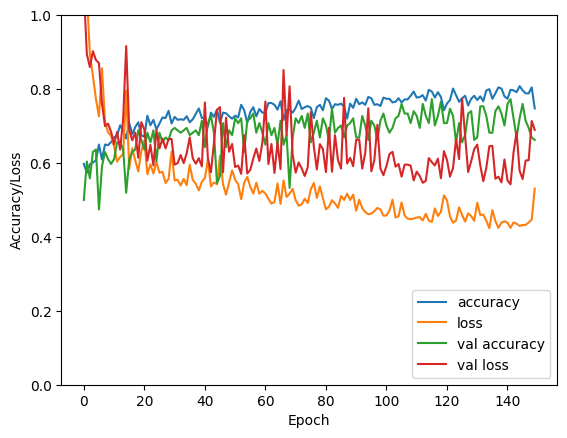

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

Cas standard d'entraînement avec léger overfitting

**Question : analyser l'accuracy pour plusieurs valeurs de learning_rate et pour plusieurs algo d'apprentissage**

In [50]:
from tqdm import tqdm

optims = [tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adam, tf.keras.optimizers.AdamW, tf.keras.optimizers.Adagrad]
lrs = [1e-1,1e-4,1e-6]
histos = []
accs = []

for opt in tqdm(optims, position=0):
    hist_lr = []
    acc_lr = []
    for lr in tqdm(lrs, position=1):
        model = my_model((8,))
        model.compile(loss='binary_crossentropy', optimizer=opt(learning_rate=lr), metrics=['accuracy'])
        tic = time.time()
        history = model.fit(x_train, y_train,validation_data=(x_val,y_val),epochs=150, batch_size=10,verbose=0)
        tac = time.time()
        # print(f"time {tac-tic}")
        _, train_accuracy = model.evaluate(x_train, y_train,verbose=0)
        _, val_accuracy = model.evaluate(x_val, y_val,verbose=0)
        acc_lr.append([train_accuracy,val_accuracy])
        hist_lr.append(history)
    
    histos.append(hist_lr)
    accs.append(acc_lr)
    


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [05:43<00:00, 68.61s/it]


# Save and load trained model

In [51]:
model_path = "temp/regressionML.keras"
model.save(model_path)
restored_model = tf.keras.models.load_model(model_path)

In [52]:
model.evaluate(x_train)
restored_model.evaluate(x_train)

20/20 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


AttributeError: in user code:

    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py", line 1853, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/menierc/PhD/miniconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 652, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'NoneType' object has no attribute 'shape'


In [ ]:
X_1=[5.8,2.6,4.0,1.2]
X_2=[6.3,3.3,6.0,2.5]
res1=model.predict([X_1])
res2=model.predict([X_2])
print('classe {0} and classe {1}'.format(round(res1[0,0]),round(res2[0,0])))

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath="./weights/weights-{epoch:03d}-{val_loss:.4f}.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [checkpoint]